# Hindcast Predictions of Equatorial Pacific SSTs

In this example, we evaluate hindcasts (retrospective forecasts) of sea surface temperatures in the eastern equatorial Pacific from CESM-DPLE. These hindcasts are evaluated against a forced ocean--sea ice simulation that initializes the model.

See the [quick start](../quick-start.html) for an analysis of time series (rather than maps) from a hindcast prediction ensemble.

In [1]:
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import climpred
from climpred import HindcastEnsemble

warnings.filterwarnings("ignore")

We'll load in a small region of the eastern equatorial Pacific for this analysis example.

In [2]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST-3D')['SST']
recon = climpred.tutorial.load_dataset('FOSI-SST-3D')['SST']
hind

<xarray.DataArray 'SST' (init: 64, lead: 10, nlat: 37, nlon: 26)>
[615680 values with dtype=float32]
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * init     (init) float32 1954.0 1955.0 1956.0 1957.0 ... 2015.0 2016.0 2017.0
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TAREA    (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

These two example products cover a small portion of the eastern equatorial Pacific.

[Text(0.5, 1.0, 'Example Data Coverage')]

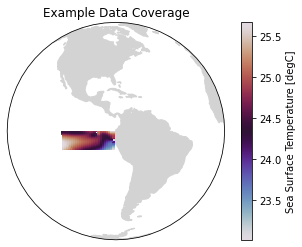

In [3]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 0))
p = ax.pcolormesh(recon.TLONG, recon.TLAT, recon.mean('time'), 
              transform=ccrs.PlateCarree(), cmap='twilight')
ax.add_feature(cfeature.LAND, color='#d3d3d3')
ax.set_global()
plt.colorbar(p, label='Sea Surface Temperature [degC]')
ax.set(title='Example Data Coverage')

It is generally advisable to do all bias correction before instantiating a `HindcastEnsemble`. However, `HindcastEnsemble` can also be modified.

`climpred` requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years,seasons,months,weeks,pentads,days`.  For the this data, the `lead` `units` are `years`. 

In [4]:
hind['lead'].attrs['units'] = 'years'

In [5]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(recon, 'Reconstruction')
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 64, lead: 10, nlat: 37, nlon: 26)
Coordinates:
 TLAT (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336 -0.1336
 TLONG (nlat, nlon) float64 250.8 251.9 253.1 254.2 ... 276.7 277.8 278.9
 * init (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
 * lead (lead) int32 1 2 3 4 5 6 7 8 9 10
 TAREA (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
Dimensions without coordinates: nlat, nlon
Data variables:
 SST (init, lead, nlat, nlon) float32 ... Initialized Ensemble Dimensions: init : 64 lead : 10 nlat : 37 nlon : 26 Coordinates: (5) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 array([[-9.750341, -9.750341, -9.750341, ..., -9.750341, -9.750341, -9.750341],
 [-9.483209, -9.483209, -9.483209, ..., -9.483209, -9.483209, -9.483209],
 [-9.216077, -9.216077, -9.216077, ..., -9.216077, -9.216077, -9.216077],
 ...,
 [-0.667832, -0.667832, -0.667832, ..., -0.667832, -0.667832, -0.667832],
 [-0.400699, -0.400699, -0.400699, ..., -0.400699, -0.400699, -0.400699],
 [-0.133566, -0.133566, -0.133566, ..., -0.133566, -0.133566, -0.133566]]) TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 277.8 278.9 array([[250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 ...,
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508]]) init (init) object 1954-01-01 00:00:00 ... 2017-01-... array([cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1984, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1985, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1986, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1987, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1988, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1989, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1990, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(19

<Verification Data Reconstruction>
Dimensions: (nlat: 37, nlon: 26, time: 68)
Coordinates:
 TLAT (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336 -0.1336
 TLONG (nlat, nlon) float64 250.8 251.9 253.1 254.2 ... 276.7 277.8 278.9
 * time (time) object 1948-01-01 00:00:00 ... 2015-01-01 00:00:00
 TAREA (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
Dimensions without coordinates: nlat, nlon
Data variables:
 SST (time, nlat, nlon) float32 25.530983 25.433725 ... 27.047922 Verification Data Reconstruction Dimensions: nlat : 37 nlon : 26 time : 68 Coordinates: (4) TLAT (nlat, nlon) float64 -9.75 -9.75 ... -0.1336 -0.1336 units : degrees_north long_name : array of t-grid latitudes array([[-9.750341, -9.750341, -9.750341, ..., -9.750341, -9.750341, -9.750341],
 [-9.483209, -9.483209, -9.483209, ..., -9.483209, -9.483209, -9.483209],
 [-9.216077, -9.216077, -9.216077, ..., -9.216077, -9.216077, -9.216077],
 ...,
 [-0.667832, -0.667832, -0.667832, ..., -0.667832, -0.667832, -0.667832],
 [-0.400699, -0.400699, -0.400699, ..., -0.400699, -0.400699, -0.400699],
 [-0.133566, -0.133566, -0.133566, ..., -0.133566, -0.133566, -0.133566]]) TLONG (nlat, nlon) float64 250.8 251.9 253.1 ... 277.8 278.9 units : degrees_east long_name : array of t-grid longitudes array([[250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 ...,
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508],
 [250.812507, 251.937507, 253.062507, ..., 276.687508, 277.812508,
 278.937508]]) time (time) object 1948-01-01 00:00:00 ... 2015-01-... array([cftime.DatetimeProlepticGregorian(1948, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1949, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1950, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1951, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1952, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1953, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1954, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1955, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1956, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1957, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1958, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1959, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1960, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1961, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1962, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1963, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1964, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1965, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1966, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1967, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1968, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1969, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1970, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1971, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1972, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1973, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1974, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1975, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1976, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1977, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1978, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1979, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1980, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1981, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1982, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1983, 1, 1, 0, 0

<AxesSubplot:xlabel='time', ylabel='SST'>

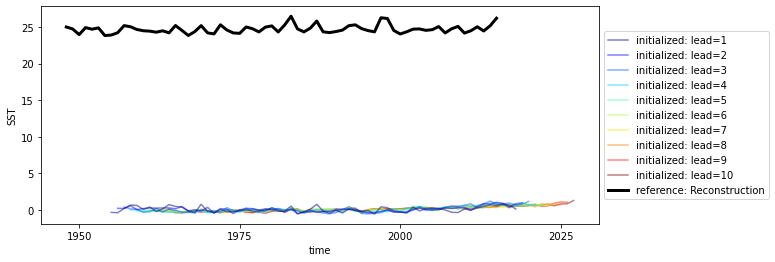

In [6]:
# quicklook at the HindEnsemble timeseries: only works for 1-dimensional data, therefore take spatial mean
hindcast.mean(['nlat','nlon']).plot()

Be careful when using xarray aggregations like `mean(dim)` on dimensions `time` or `init/lead`. 
If you only do `hindcast-hindcast.mean('time')` at the same time, the `initialized` will become all zeros.

In [7]:
# Remove 1964-2014 climatology
hindcast = hindcast - hindcast.sel(time=slice('1964', '2014')).mean('time').sel(init=slice('1964', '2014')).isel(lead=0).mean('init')

<AxesSubplot:xlabel='time', ylabel='SST'>

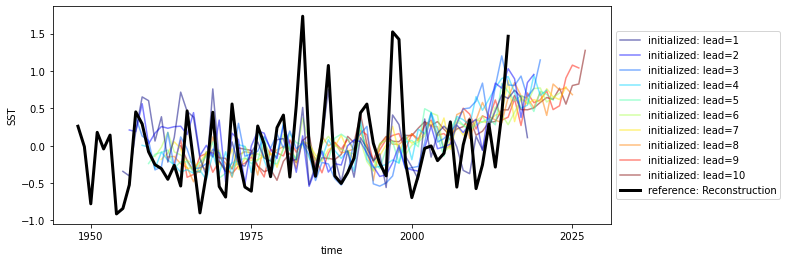

In [8]:
hindcast.mean(['nlat','nlon']).plot()

We first need to remove the same climatology that was used to drift-correct the CESM-DPLE. Then we'll create a detrended version of our two products to assess detrended predictability.

We'll also detrend the reconstruction over its `time` dimension and initialized forecast ensemble over `init`.

In [9]:
from esmtools.stats import rm_trend

hindcast = hindcast.map(rm_trend, dim='init').map(rm_trend, dim='time')

<AxesSubplot:xlabel='time', ylabel='SST'>

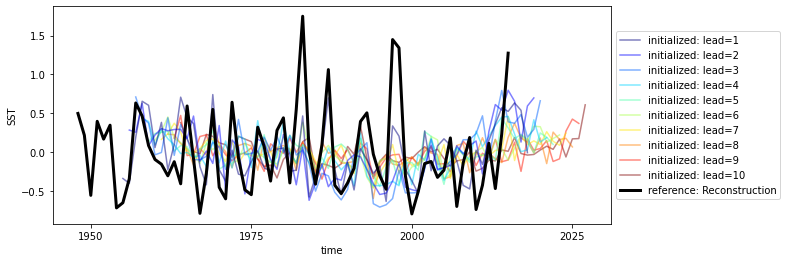

In [10]:
hindcast.mean(['nlat','nlon']).plot()

Although functions can be called directly in `climpred`, we suggest that you use our classes (`HindcastEnsemble` and `PerfectModelEnsemble`) to make analysis code cleaner.

## Anomaly Correlation Coefficient of SSTs

We can now compute the ACC over all leads and all grid cells.

In [11]:
predictability = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='same_verif')
print(predictability)

<xarray.Dataset>
Dimensions:  (lead: 10, nlat: 37, nlon: 26, skill: 1)
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TLONG    (nlat, nlon) float64 250.8 251.9 253.1 254.2 ... 276.7 277.8 278.9
    TAREA    (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
  * skill    (skill) <U4 'init'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (lead, nlat, nlon) float64 0.5079 0.5049 0.5024 ... 0.0701 0.08838


We use the `pval` keyword to get associated p-values for our ACCs. We can then mask our final maps based on $\alpha = 0.05$.

In [12]:
significance = hindcast.verify(metric='p_pval', comparison='e2o', dim='init', alignment='same_verif')
# FIX: add missing coords to results
significance.coords['TLAT'] = hind['TLAT']
predictability.coords['TLAT'] = hind['TLAT']

In [13]:
# Mask latitude and longitude by significance for stippling.
siglat = significance.TLAT.where(significance.SST <= 0.05)
siglon = significance.TLONG.where(significance.SST <= 0.05)

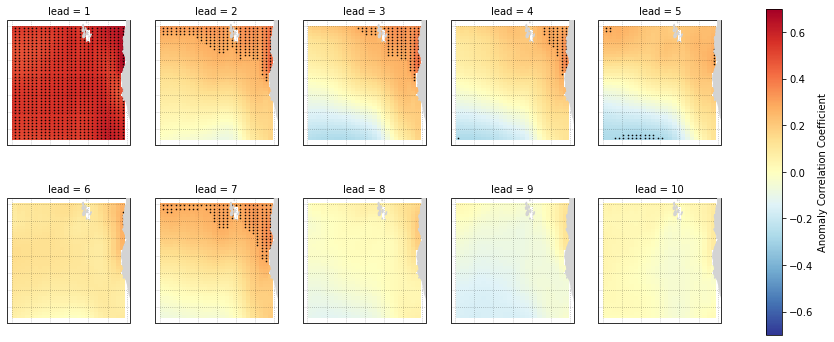

In [14]:
p = predictability.SST.plot.pcolormesh(x='TLONG', y='TLAT',
                                       transform=ccrs.PlateCarree(),
                                       col='lead', col_wrap=5,
                                       subplot_kws={'projection': ccrs.PlateCarree(),
                                                    'aspect': 3},
                                       cbar_kwargs={'label': 'Anomaly Correlation Coefficient'},
                                       vmin=-0.7, vmax=0.7,
                                       cmap='RdYlBu_r')
for i, ax in enumerate(p.axes.flat):
    ax.add_feature(cfeature.LAND, color='#d3d3d3', zorder=4)
    ax.gridlines(alpha=0.3, color='k', linestyle=':')
    # Add significance stippling
    ax.scatter(siglon.isel(lead=i), 
               siglat.isel(lead=i), 
               color='k', 
               marker='.', 
               s=1.5,
               transform=ccrs.PlateCarree())

## Root Mean Square Error of SSTs

We can also check error in our forecasts, just by changing the metric keyword.

In [15]:
rmse = hindcast.verify(metric='rmse', comparison='e2o', dim='init', alignment='same_verif')
rmse.coords['TLAT'] = hind['TLAT']

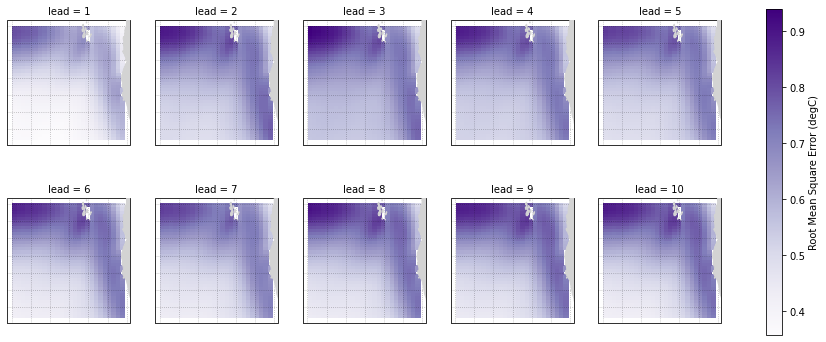

In [16]:
p = rmse.SST.plot.pcolormesh(x='TLONG', y='TLAT',
                            transform=ccrs.PlateCarree(),
                            col='lead', col_wrap=5,
                            subplot_kws={'projection': ccrs.PlateCarree(),
                                        'aspect': 3},
                            cbar_kwargs={'label': 'Root Mean Square Error (degC)'},
                            cmap='Purples')
for ax in p.axes.flat:
    ax.add_feature(cfeature.LAND, color='#d3d3d3', zorder=4)
    ax.gridlines(alpha=0.3, color='k', linestyle=':')